# Course Project - Real-World Machine Learning Model
Machine Learning with Python: Zero to GBMs

### Airbnb New User Bookings
--Where will a new guest book their first travel experience?

![](https://imgur.com/RBJ5YSd.png)      


Let's begin by installing the required libraries.

In [65]:
#restart the kernel after installation
%pip install numpy pandas-profiling matplotlib seaborn plotly --quiet
%pip install jovian opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Problem Statement

This little project will explore the data on Kaggle about AirBNB New user bookings.

> Airbnb was born in 2007 when two Hosts welcomed three guests to their San Francisco home, and has since grown to over 4 million Hosts who have welcomed more than 1 billion guest arrivals in almost every country across the globe. Every day, Hosts offer unique stays and experiences that make it possible for guests to connect with communities in a more authentic way.
>
> Some fun facts
>> 6M active listings worldwide
>>
>> 100K cities and towns with active Airbnb listings
>>
>> 220+ countries and regions with Airbnb listings
>>
>> 1B+ Airbnb guest arrivals all-time
>
> View and download the data here: https://www.kaggle.com/competitions/airbnb-recruiting-new-user-bookings

## Downloading the Data

We can download the dataset from Kaggle directly within the Jupyter notebook using the `opendatasets` library. Make sure to `accept the competition rules` before executing the following cell.

In [66]:
# import jovian
import os
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (15, 4)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [67]:
od.download('https://www.kaggle.com/competitions/airbnb-recruiting-new-user-bookings')

Skipping, found downloaded files in ".\airbnb-recruiting-new-user-bookings" (use force=True to force download)


You'll be asked to provide your Kaggle credentials to download the data. Follow these instructions: http://bit.ly/kaggle-creds

In [68]:
data_dir =  'airbnb-recruiting-new-user-bookings'
os.listdir(data_dir)

['age_gender_bkts.csv.zip',
 'countries.csv.zip',
 'sample_submission_NDF.csv.zip',
 'sessions.csv.zip',
 'test_users.csv.zip',
 'train_users_2.csv.zip']

Let's load the data into Pandas dataframes by reading through `zip` file

In [69]:
train_df = pd.read_csv(data_dir + '/train_users_2.csv.zip', low_memory=False)
test_df = pd.read_csv(data_dir + '/test_users.csv.zip')
session_df = pd.read_csv(data_dir + '/sessions.csv.zip')
countries_df = pd.read_csv(data_dir + '/countries.csv.zip')
age_gender_df = pd.read_csv(data_dir + '/age_gender_bkts.csv.zip')
submission_df = pd.read_csv(data_dir + '/sample_submission_NDF.csv.zip')

## Preprocessing data

### Let's explore the `train_df` and `test_df` first

>From the Kaggle page, we are provided with some detailed information:
* signup_flow: the page a user came to signup up from
* affiliate_channel: what kind of paid marketing
* affiliate_provider: where the marketing is e.g. google, craigslist, other
* first_affiliate_tracked: whats the first marketing the user interacted with before the signing up
* **country_destination**: this is the target variable you are to predict

In [70]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

It's seem like the data is already cleaned, only the `age, date_first_booking, first_affiliate_tracked` are still missing some samples

In [71]:
train_df.describe(include='all')

id date_account_created  timestamp_first_active  \
count       213451               213451               213451.00   
unique      213451                 1634                     NaN   
top     gxn3p5htnn           2014-05-13                     NaN   
freq             1                  674                     NaN   
mean           NaN                  NaN       20130850417367.26   
std            NaN                  NaN           9253717046.58   
min            NaN                  NaN       20090319043255.00   
25%            NaN                  NaN       20121225073327.50   
50%            NaN                  NaN       20130911061308.00   
75%            NaN                  NaN       20140306082494.00   
max            NaN                  NaN       20140630235824.00   

       date_first_booking     gender       age signup_method  signup_flow  \
count               88908     213451 125461.00        213451    213451.00   
unique               1976          4       NaN             3          NaN   
top            2014-05-22  -unknown-       NaN         basic          NaN   
freq                  248      95688       NaN        152897          NaN   
mean                  NaN        NaN     49.67           NaN         3.27   
std                   NaN        NaN    155.67           NaN         7.64   
min                   NaN        NaN      1.00           NaN         0.00   
25%                   NaN        NaN     28.00           NaN         0.00   
50%                   NaN        NaN     34.00           NaN         0.00   
75%                   NaN        NaN     43.00           NaN         0.00   
max                   NaN        NaN   2014.00           NaN        25.00   

       language affiliate_channel affiliate_provider first_affiliate_tracked  \
count    213451            213451             213451                  207386   
unique       25                 8                 18                       7   
top          en            direct             direct               untracked   
freq     206314            137727             137426                  109232   
mean        NaN               NaN                NaN                     NaN   
std         NaN               NaN                NaN                     NaN   
min         NaN               NaN                NaN                     NaN   
25%         NaN               NaN                NaN                     NaN   
50%         NaN               NaN                NaN                     NaN   
75%         NaN               NaN                NaN                     NaN   
max         NaN               NaN                NaN                     NaN   

       signup_app first_device_type first_browser country_destination  
count      213451            213451        213451              213451  
unique          4                 9            52                  12  
top           Web       Mac Desktop        Chrome                 NDF  
freq       182717             89600         63845              124543  
mean          NaN               NaN           NaN                 NaN  
std           NaN               NaN           NaN                 NaN  
min           NaN               NaN           NaN                 NaN  
25%           NaN               NaN           NaN                 NaN  
50%           NaN               NaN           NaN                 NaN  
75%           NaN               NaN           NaN                 NaN  
max           NaN               NaN           NaN                 NaN

As observed, `age` value range is a bit weird. Let make it a bit more "natural"

In [72]:
train_df[(train_df.age > 100) | (train_df.age < 18)].age.count()

2503

In [73]:
def clean_age(df):
    df.loc[(df.age > 100) | (df.age < 18), 'age'] = np.nan
    df['age'] = df['age'].astype('Int64')

In [74]:
clean_age(train_df)
clean_age(test_df)
# train_df.age.isnull().sum()
# train_df.age.describe()

Interesting enough, it is seems like that 54% of non-booking users didn't give their age info and obviously, no booking day for them as well

In [75]:
# Compute:
total_data_NDF = train_df[train_df.country_destination == 'NDF'].shape[0]
percen_null_NDF = (train_df[train_df.country_destination == 'NDF'].isnull().sum() * 100 / total_data_NDF).sort_values(ascending=False)[:4]
# Display:
pd.set_option('display.float_format', lambda x: f"{x:.2f}")
print("Users with no booking: ")
percen_null_NDF

Users with no booking: 


date_first_booking        100.00
age                        55.22
first_affiliate_tracked     3.47
id                          0.00
dtype: float64


Let's check other columns

In [76]:
for column in train_df.columns[4:-3]:
    if column == 'age': continue
    print(f"{column}: {train_df[column].unique()}\n")
# print(train_df['signup_method'].unique())


gender: ['-unknown-' 'MALE' 'FEMALE' 'OTHER']

signup_method: ['facebook' 'basic' 'google']

signup_flow: [ 0  3  2  1 24  8  6  5 10 25 12  4 16 15 20 21 23]

language: ['en' 'fr' 'de' 'es' 'it' 'pt' 'zh' 'ko' 'ja' 'ru' 'pl' 'el' 'sv' 'nl'
 'hu' 'da' 'id' 'fi' 'no' 'tr' 'th' 'cs' 'hr' 'ca' 'is']

affiliate_channel: ['direct' 'seo' 'other' 'sem-non-brand' 'content' 'sem-brand'
 'remarketing' 'api']

affiliate_provider: ['direct' 'google' 'other' 'craigslist' 'facebook' 'vast' 'bing' 'meetup'
 'facebook-open-graph' 'email-marketing' 'yahoo' 'padmapper' 'gsp' 'wayn'
 'naver' 'baidu' 'yandex' 'daum']

first_affiliate_tracked: ['untracked' 'omg' nan 'linked' 'tracked-other' 'product' 'marketing'
 'local ops']

signup_app: ['Web' 'Moweb' 'iOS' 'Android']



In [77]:
train_df.gender.value_counts()

-unknown-    95688
FEMALE       63041
MALE         54440
OTHER          282
Name: gender, dtype: int64

In [78]:
train_df[(train_df.gender == 'other') | (train_df.gender == '-unknown-')].describe(include='all')

id date_account_created  timestamp_first_active  \
count        95688                95688                95688.00   
unique       95688                 1622                     NaN   
top     gxn3p5htnn           2014-06-24                     NaN   
freq             1                  364                     NaN   
mean           NaN                  NaN       20132175233187.25   
std            NaN                  NaN           9040777195.68   
min            NaN                  NaN       20090319043255.00   
25%            NaN                  NaN       20130414172643.25   
50%            NaN                  NaN       20131101205214.00   
75%            NaN                  NaN       20140325203915.00   
max            NaN                  NaN       20140630235824.00   

       date_first_booking     gender      age signup_method  signup_flow  \
count               29018      95688 16118.00         95688     95688.00   
unique               1893          1     <NA>             3          NaN   
top            2014-05-22  -unknown-     <NA>         basic          NaN   
freq                   99      95688     <NA>         93755          NaN   
mean                  NaN        NaN    36.95           NaN         4.18   
std                   NaN        NaN    12.08           NaN         8.81   
min                   NaN        NaN    18.00           NaN         0.00   
25%                   NaN        NaN    29.00           NaN         0.00   
50%                   NaN        NaN    34.00           NaN         0.00   
75%                   NaN        NaN    43.00           NaN         0.00   
max                   NaN        NaN   100.00           NaN        25.00   

       language affiliate_channel affiliate_provider first_affiliate_tracked  \
count     95688             95688              95688                   91783   
unique       24                 8                 18                       7   
top          en            direct             direct               untracked   
freq      92955             63290              63132                   49016   
mean        NaN               NaN                NaN                     NaN   
std         NaN               NaN                NaN                     NaN   
min         NaN               NaN                NaN                     NaN   
25%         NaN               NaN                NaN                     NaN   
50%         NaN               NaN                NaN                     NaN   
75%         NaN               NaN                NaN                     NaN   
max         NaN               NaN                NaN                     NaN   

       signup_app first_device_type first_browser country_destination  
count       95688             95688         95688               95688  
unique          4                 9            43                  12  
top           Web       Mac Desktop        Chrome                 NDF  
freq        78964             35322         25005               66670  
mean          NaN               NaN           NaN                 NaN  
std           NaN               NaN           NaN                 NaN  
min           NaN               NaN           NaN                 NaN  
25%           NaN               NaN           NaN                 NaN  
50%           NaN               NaN           NaN                 NaN  
75%           NaN               NaN           NaN                 NaN  
max           NaN               NaN           NaN                 NaN

As can be seen, the `other` and `unknown` gender have nothing special in related to the given data, thus, let's generalized them as `unknown`

In [79]:
train_df['gender'] = train_df['gender'].replace('OTHER', "-unknown-")
test_df['gender'] = test_df['gender'].replace('OTHER', "-unknown-")
# test_df.gender.value_counts(dropna=False)

### Let's do some data cleaning:
* Reformat the dates columns
* Replace those NaN in first_affiliate_tracked as `untracked`

In [80]:
def format_timestamp(timestamp_str):
    tmp = str(timestamp_str)
    return tmp[0:4] + '-' + tmp[4:6] + '-' + tmp[6:8] + ' ' + tmp[8:10] + ':' + tmp[10:12] + ':' + tmp[12:14]

def train_test_process(df):
    df['date_account_created'] = pd.to_datetime(df['date_account_created'])
    df['date_first_booking'] = pd.to_datetime(df['date_first_booking'])
    df['timestamp_first_active'] = df['timestamp_first_active'].apply(format_timestamp)

    df['first_affiliate_tracked'].fillna(value='untracked', inplace=True)

In [81]:
train_test_process(train_df)
train_test_process(test_df)

### Let's move on the countries_df

In [82]:
# countries_df = pd.read_csv(data_dir + '/countries.csv.zip')
countries_df

country_destination  lat_destination  lng_destination  distance_km  \
0                  AU           -26.85           133.28     15297.74   
1                  CA            62.39           -96.82      2828.13   
2                  DE            51.17            10.45      7879.57   
3                  ES            39.90            -2.49      7730.72   
4                  FR            46.23             2.21      7682.94   
5                  GB            54.63            -3.43      6883.66   
6                  IT            41.87            12.56      8636.63   
7                  NL            52.13             5.30      7524.32   
8                  PT            39.55            -7.84      7355.25   
9                  US            36.97           -95.84         0.00   

   destination_km2 destination_language   language_levenshtein_distance  
0       7741220.00                   eng                           0.00  
1       9984670.00                   eng                           0.00  
2        357022.00                   deu                          72.61  
3        505370.00                   spa                          92.25  
4        643801.00                   fra                          92.06  
5        243610.00                   eng                           0.00  
6        301340.00                   ita                          89.40  
7         41543.00                   nld                          63.22  
8         92090.00                   por                          95.45  
9       9826675.00                   eng                           0.00

In [83]:
# print(f"All \"target\" countries:\n{train_df['country_destination'].unique()}\n")
print(f"Languages in train_df: {train_df['language'].unique()}\n")
print(f"Languages in countries_df: {countries_df['destination_language '].unique()}\n")

Languages in train_df: ['en' 'fr' 'de' 'es' 'it' 'pt' 'zh' 'ko' 'ja' 'ru' 'pl' 'el' 'sv' 'nl'
 'hu' 'da' 'id' 'fi' 'no' 'tr' 'th' 'cs' 'hr' 'ca' 'is']

Languages in countries_df: ['eng' 'deu' 'spa' 'fra' 'ita' 'nld' 'por']



Let's generalize the Langue short code here for easier processing later if needed

In [84]:
countries_df['language_dest'] = countries_df['destination_language ']

# Replace Language Code 3 with Code 2
lang_code3 = countries_df['destination_language '].unique().tolist()
lang_code2 = ['en', 'de', 'es', 'fr', 'it', 'nl', 'pt']
for i in range(len(lang_code3)):
    countries_df['language_dest'] = countries_df['language_dest'].replace(lang_code3[i], lang_code2[i])

# countries_df

Let's merge the these into our `train_df` and `test_df`

> Note that other data such as distance can be applied if there are further researches about website, affiliate's location (for e.g., naver is popular in Korea)

### Move on to `session_df`

In [85]:
session_df

user_id            action action_type  \
0         d1mm9tcy42            lookup         NaN   
1         d1mm9tcy42    search_results       click   
2         d1mm9tcy42            lookup         NaN   
3         d1mm9tcy42    search_results       click   
4         d1mm9tcy42            lookup         NaN   
...              ...               ...         ...   
10567732  9uqfg8txu3         dashboard        view   
10567733  9uqfg8txu3              edit        view   
10567734  9uqfg8txu3     webcam_upload   -unknown-   
10567735  9uqfg8txu3            active   -unknown-   
10567736  9uqfg8txu3  show_personalize        data   

                        action_detail      device_type  secs_elapsed  
0                                 NaN  Windows Desktop        319.00  
1                 view_search_results  Windows Desktop      67753.00  
2                                 NaN  Windows Desktop        301.00  
3                 view_search_results  Windows Desktop      22141.00  
4                                 NaN  Windows Desktop        435.00  
...                               ...              ...           ...  
10567732                    dashboard  Windows Desktop        556.00  
10567733                 edit_profile  Windows Desktop       6624.00  
10567734                    -unknown-  Windows Desktop     200125.00  
10567735                    -unknown-        -unknown-      17624.00  
10567736  user_profile_content_update  Windows Desktop       1221.00  

[10567737 rows x 6 columns]

In [86]:
session_df_count = session_df.shape[0]

invalid_id_count = session_df['user_id'].isnull().sum()
print(f"Percentage of invalid user_id: {invalid_id_count / session_df_count * 100:.5f}%")

Percentage of invalid user_id: 0.32643%


Let's drop those rows with invalid `user_id`

In [87]:
session_c_df = session_df.copy()
session_c_df.dropna(axis=0, subset=['user_id'], inplace=True)

Next, check the the link between action_type and action_detail, whether there are any missing data

In [88]:
# session_c_df[session_c_df['action_type'] == '-unknown-'].action_detail.value_counts(dropna=False)
print(session_c_df[(session_c_df['action_type'].isnull()) | (session_c_df['action_type'] == '-unknown-')].action_type.value_counts(dropna=False))
print(session_c_df[(session_c_df['action_detail'].isnull()) | (session_c_df['action_detail'] == '-unknown-')].action_detail.value_counts(dropna=False), end = "\n\n")

print(session_c_df[session_c_df['action_type'] == '-unknown-'].action_detail.value_counts(dropna=False))

NaN          1122957
-unknown-    1028251
Name: action_type, dtype: int64
NaN          1122957
-unknown-    1028222
Name: action_detail, dtype: int64

-unknown-        1028222
phone_numbers         27
reservations           2
Name: action_detail, dtype: int64


There are some logs show that NaN action_type means NaN action_detail, which might be because of the missing data. However, some `unknown` action_type still have specifical action_detail.
Hence, let's replace those `unknown` data that appear in both columns with NaN

In [89]:
session_c_df.loc[session_c_df['action_detail'] == '-unknown-', ['action_type', 'action_detail']] = np.nan
# print(session_c_df[(session_c_df['action_type'].isnull()) | (session_c_df['action_type'] == '-unknown-')].action_type.value_counts(dropna=False))
# print(session_c_df[(session_c_df['action_detail'].isnull()) | (session_c_df['action_detail'] == '-unknown-')].action_detail.value_counts(dropna=False), end = "\n\n")

In [90]:
print(session_c_df[session_c_df['action_detail'] == 'reservations'].action_type.unique())
print(session_c_df[session_c_df['action_detail'] == 'phone_numbers'].action_type.unique())

['data' '-unknown-']
['-unknown-']


In addition, the only 2 `unknown` action_type with `reservations` action_detail show some errors in data collecting as the majority of these are listed as `data` in action_type column. And for the `phone_number`, a new action_type can be made. 

Let's modify the `unknown` in action_type according to these two action_detail 

In [91]:
session_c_df.loc[session_c_df['action_detail'] == 'reservations', 'action_type'] = 'data'
session_c_df.loc[session_c_df['action_detail'] == 'phone_numbers', 'action_type'] = 'phone'

Let's only consider the top common actions and create a new dataframe base on the `seconds elapsed` of each action, in which `user_id` are still the index

In [92]:
# session_df['action'].value_counts().sort_values(ascending=False).iloc[60:70]
top_actions = list(session_df['action'].value_counts().sort_values(ascending=False).index)[:70]

In [93]:
action_df = session_df[session_df['action'].isin(top_actions)].groupby(by=['user_id','action'])["secs_elapsed"].sum().reset_index().pivot_table('secs_elapsed',index=['user_id'],columns='action')
action_df

action      account    active  agree_terms_check  ajax_check_dates  \
user_id                                                              
00023iyk9l      NaN       NaN                NaN               NaN   
0010k6l0om      NaN       NaN                NaN               NaN   
001wyh0pz8      NaN  21931.00                NaN               NaN   
0028jgx1x1      NaN    489.00                NaN               NaN   
002qnbzfs5      NaN 185587.00                NaN               NaN   
...             ...       ...                ...               ...   
zzxox7jnrx      NaN       NaN                NaN               NaN   
zzy7t0y9cm      NaN       NaN                NaN               NaN   
zzysuoqg6x      NaN       NaN                NaN               NaN   
zzywmcn0jv      NaN       NaN                NaN           1061.00   
zzzlylp57e      NaN       NaN          106850.00             44.00   

action      ajax_get_referrals_amt  ajax_image_upload  ajax_lwlb_contact  \
user_id                                                                    
00023iyk9l                     NaN                NaN                NaN   
0010k6l0om                     NaN                NaN                NaN   
001wyh0pz8                     NaN                NaN                NaN   
0028jgx1x1                     NaN                NaN                NaN   
002qnbzfs5                     NaN                NaN                NaN   
...                            ...                ...                ...   
zzxox7jnrx                     NaN                NaN                NaN   
zzy7t0y9cm                     NaN                NaN                NaN   
zzysuoqg6x                     NaN                NaN                NaN   
zzywmcn0jv                     NaN                NaN          280030.00   
zzzlylp57e                     NaN                NaN           18112.00   

action      ajax_photo_widget_form_iframe  ajax_refresh_subtotal  \
user_id                                                            
00023iyk9l                            NaN                1447.00   
0010k6l0om                            NaN               20110.00   
001wyh0pz8                            NaN                    NaN   
0028jgx1x1                            NaN                    NaN   
002qnbzfs5                            NaN                    NaN   
...                                   ...                    ...   
zzxox7jnrx                            NaN               45428.00   
zzy7t0y9cm                            NaN                 664.00   
zzysuoqg6x                            NaN                    NaN   
zzywmcn0jv                            NaN              138805.00   
zzzlylp57e                            NaN               10622.00   

action      apply_reservation  ask_question  authenticate  available  \
user_id                                                                
00023iyk9l                NaN           NaN           NaN        NaN   
0010k6l0om                NaN           NaN           NaN        NaN   
001wyh0pz8                NaN           NaN           NaN        NaN   
0028jgx1x1                NaN           NaN           NaN        NaN   
002qnbzfs5                NaN           NaN           NaN        NaN   
...                       ...           ...           ...        ...   
zzxox7jnrx                NaN           NaN           NaN        NaN   
zzy7t0y9cm                NaN           NaN           NaN        NaN   
zzysuoqg6x                NaN           NaN           NaN        NaN   
zzywmcn0jv                NaN       1091.00           NaN        NaN   
zzzlylp57e                NaN        927.00           NaN        NaN   

action      calendar_tab_inner2  callback  campaigns  cancellation_policies  \
user_id                                                                       
00023iyk9l                  NaN      0.00        NaN                    NaN   
0010k6l0om                  NaN      0.00

In [94]:
devices_df = session_c_df.groupby(['user_id'])["device_type"].nunique().reset_index()
devices_df         

user_id  device_type
0       00023iyk9l            2
1       0010k6l0om            1
2       001wyh0pz8            1
3       0028jgx1x1            2
4       002qnbzfs5            2
...            ...          ...
135478  zzxox7jnrx            1
135479  zzy7t0y9cm            1
135480  zzysuoqg6x            1
135481  zzywmcn0jv            1
135482  zzzlylp57e            1

[135483 rows x 2 columns]

Another interesting thing about the dataset is the user_id, which is not fit between session and train/test data

In [95]:
print(session_c_df.user_id.unique().shape[0])
print(train_df.id.unique().shape[0])
print(test_df.id.unique().shape[0])

135483
213451
62096


***
## Exploratory data analysis and visualization on the dataset
***

Let's check the train and test data first

<AxesSubplot:xlabel='country_destination', ylabel='count'>

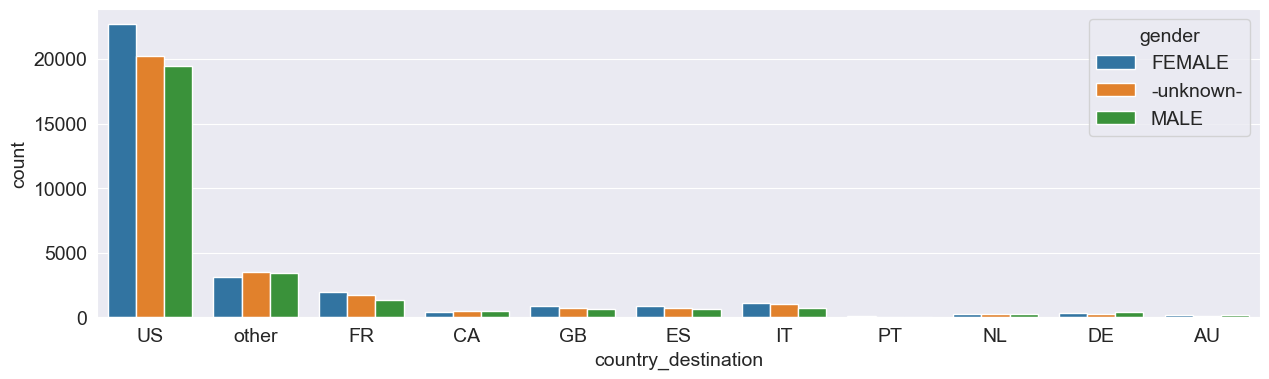

In [96]:
sns.countplot(  data=train_df[train_df["country_destination"] != "NDF"], 
                x='country_destination',
                hue='gender')

According to the data, the US destination takes over the majority of booking. The distribution of gender among the booked country is reasonably the same.

In [97]:
train_df['booked'] = train_df['country_destination'].apply(lambda x: 1 if x != 'NDF' else 0)

In [98]:
px.histogram(train_df, 
           x='age', 
           y='booked',
           nbins=100, # Since the distribution is between 18 and 100
           color='gender')

In [99]:
tmp1 = train_df[train_df['booked'] == 1]['age'].mode()[0]
tmp2 = train_df[(train_df['booked'] == 1) & (train_df['age'] == tmp1)]

print("The age that booked the most: ", tmp1)
print(f"And among that, gender of {tmp2['gender'].value_counts().index[0]} is the most")

The age that booked the most:  30
And among that, gender of FEMALE is the most


<AxesSubplot:xlabel='country_destination', ylabel='age'>

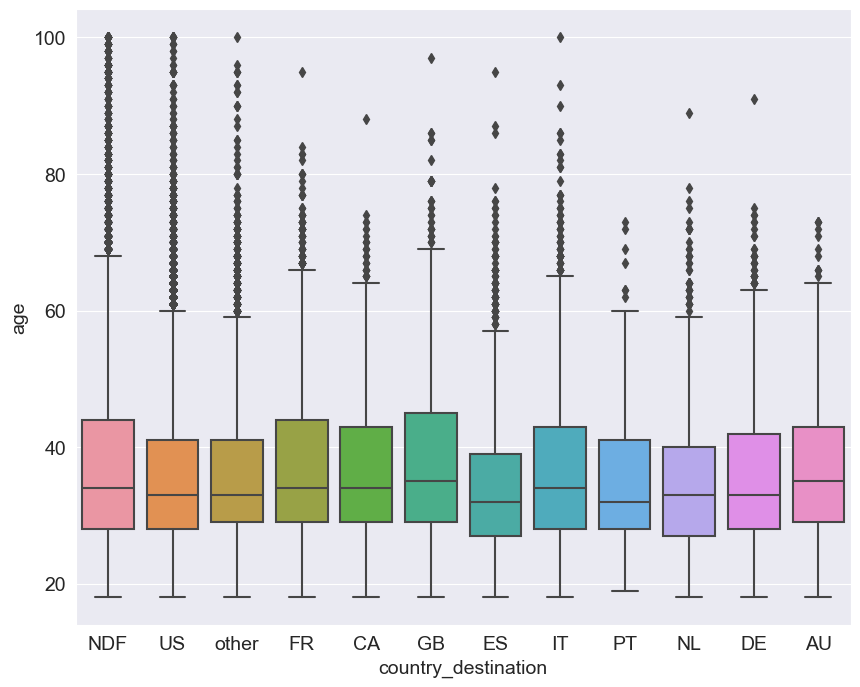

In [100]:
plt.figure(figsize=(10,8))
sns.boxplot(x="country_destination", y="age", data=train_df)

Since the age does not varies much between the choice of destinated countries, thus, it might not be beneficial for using as model's input

Also, in test data, seems like the first active timestamp show the same date as the account-created date, which unfortunately not useful for predicting.

In [101]:
columns = test_df.columns
test_df[columns[1:3]].sample(10)

date_account_created timestamp_first_active
20616           2014-07-30    2014-07-30 17:13:07
60355           2014-09-28    2014-09-28 06:26:12
3158            2014-07-06    2014-07-06 22:21:55
51871           2014-09-14    2014-09-14 14:46:51
54705           2014-09-18    2014-09-18 21:05:23
56465           2014-09-21    2014-09-21 23:08:00
51095           2014-09-13    2014-09-13 02:03:51
11714           2014-07-19    2014-07-19 23:01:19
21006           2014-07-31    2014-07-31 01:02:07
10240           2014-07-18    2014-07-18 02:03:37

The number of booking varied between months, probably due to the weather and the cultural activities during that time. Here, let's compared between the year 2012 and 2013

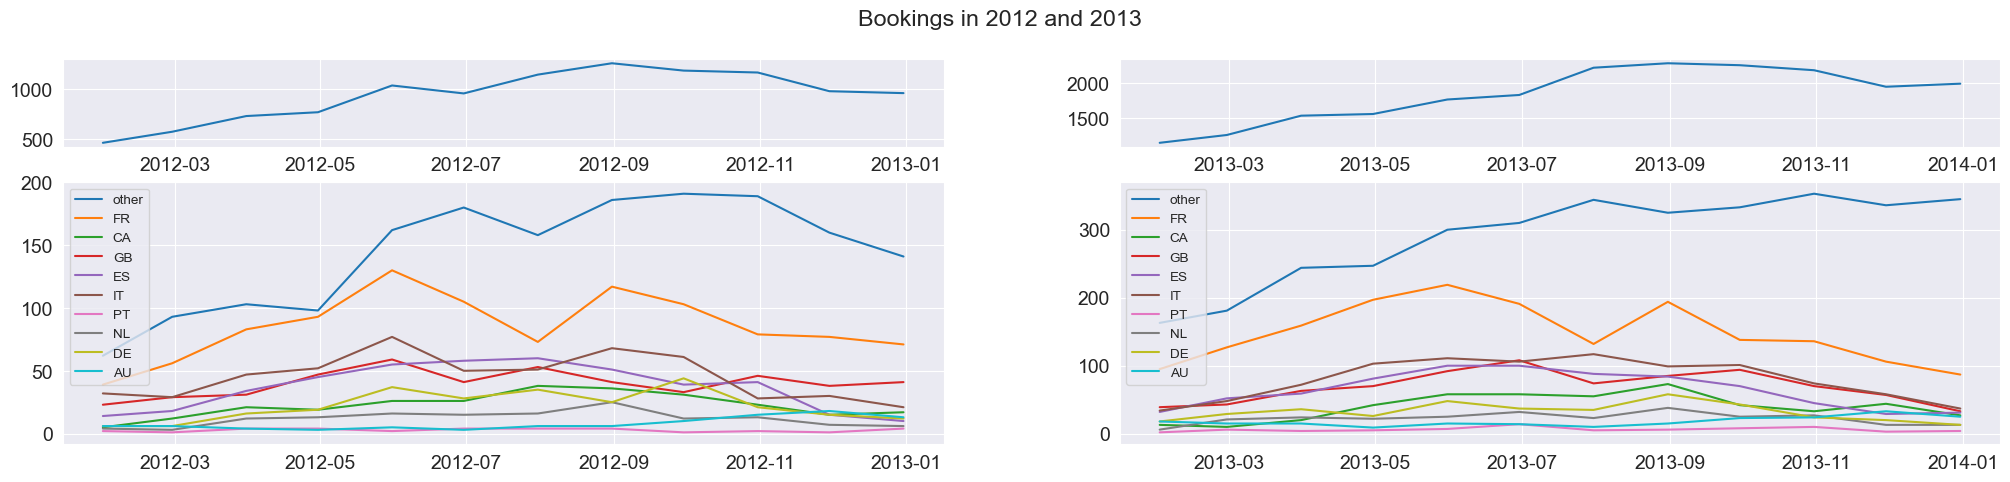

In [102]:
# Reference https://www.kaggle.com/code/mohamedelgebaly/airbnb-vf#EDA

import datetime as dt

booked_df = train_df[train_df['booked'] == 1]

fig, axs = plt.subplots(2, 2, figsize=(25,5), gridspec_kw={'height_ratios': [1, 3]})
fig.suptitle('Bookings in 2012 and 2013')

mask12 = (booked_df['date_first_booking'] > dt.datetime(2012, 1, 1)) & (booked_df['date_first_booking'] <= dt.datetime(2012, 12, 31))
mask13 = (booked_df['date_first_booking'] > dt.datetime(2013, 1, 1)) & (booked_df['date_first_booking'] <= dt.datetime(2013, 12, 31))

# Due to the high number of US bookings, plot for US bookings is separated
data_us_12 = booked_df['date_first_booking'].loc[(mask12)&(booked_df.country_destination=='US')].value_counts().resample('M').sum()
axs[0, 0].plot(data_us_12)

data_us_13 = booked_df['date_first_booking'].loc[(mask13)&(booked_df.country_destination=='US')].value_counts().resample('M').sum()
axs[0, 1].plot(data_us_13)

booked_df = train_df[train_df['booked'] == 1].copy()
for i in booked_df.country_destination.unique():
    if i != 'US': 
        data_12 = booked_df['date_first_booking'].loc[(mask12)&(booked_df.country_destination==i)].value_counts().resample('M').sum()
        axs[1, 0].plot(data_12, label=i)
        axs[1, 0].legend(loc = 'best', fontsize='x-small')
        data_13 = booked_df['date_first_booking'].loc[(mask13)&(booked_df.country_destination==i)].value_counts().resample('M').sum()
        axs[1, 1].plot(data_13, label=i)
        axs[1, 1].legend(loc = 'upper left', fontsize='x-small')




Let's further examine the number of booking and number of new account created per week over the dataset interval
* Both features have approximately the same shape and trend line, which can conclude that users at these time prefer to create a account for bookings or after booking.
* The dataset seems to be missing some data for account creation after mid 2014
* It saw a slight drop during Christmas and new year time, then increased gradually over the months


Text(0.5, 1.0, 'Number of Bookings and New accounts per Week')

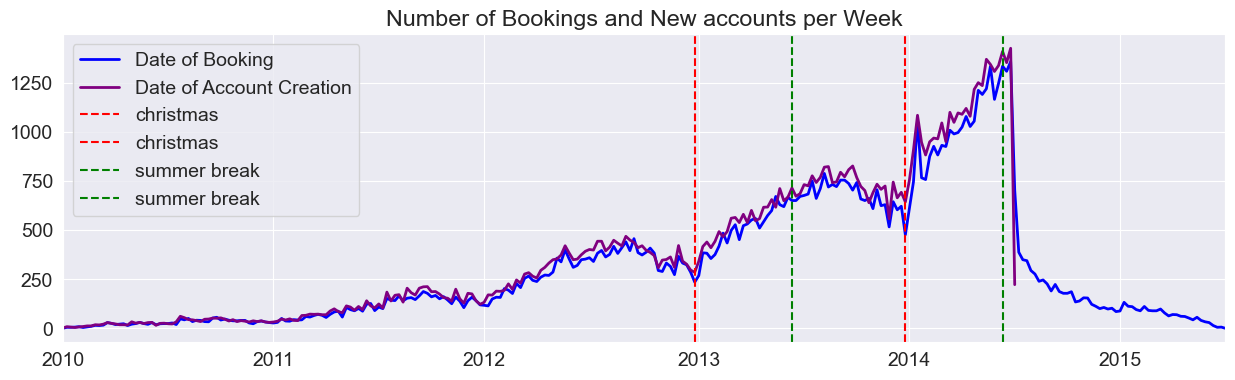

In [103]:
plt.figure(figsize=(15,4))
booked_df['date_first_booking'].value_counts().resample('w').sum().plot.line(linewidth=2,color='blue',label= 'Date of Booking')
booked_df['date_account_created'].value_counts().resample('W').sum().plot.line(linewidth=2,color='purple', label= 'Date of Account Creation')
plt.axvline(dt.datetime(2012, 12, 25),color='r', linestyle='--', label= 'christmas')
plt.axvline(dt.datetime(2013, 12, 25),color='r', linestyle='--', label= 'christmas')
plt.axvline(dt.datetime(2013, 6, 14),color='g', linestyle='--', label= 'summer break')
plt.axvline(dt.datetime(2014, 6, 14),color='g', linestyle='--', label= 'summer break')

plt.legend()
plt.title('Number of Bookings and New accounts per Week')

<AxesSubplot:xlabel='affiliate_channel', ylabel='count'>

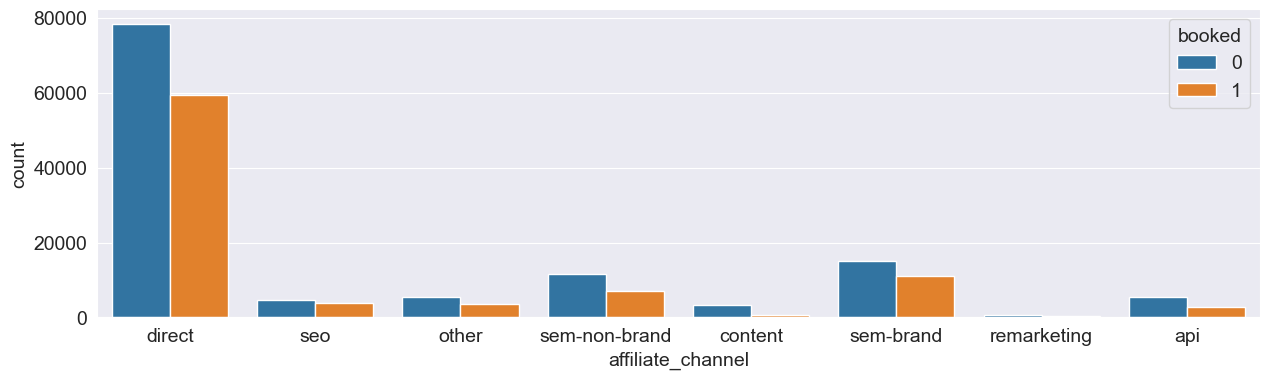

In [104]:
sns.countplot(data=train_df, x='affiliate_channel', hue='booked')


<AxesSubplot:xlabel='country_destination', ylabel='count'>

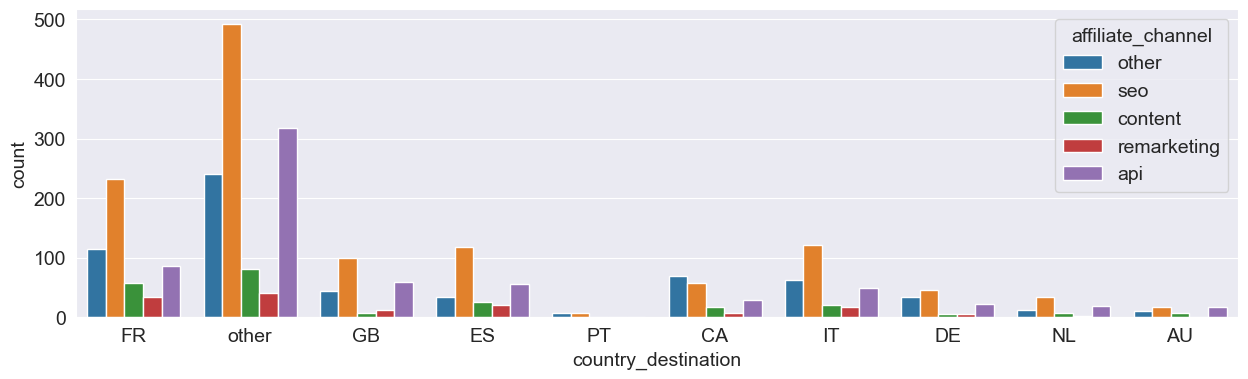

In [105]:
affi_channel_idx = train_df['affiliate_channel'].value_counts(ascending=True).index.tolist()
# affi_df = train_df.set_index('affiliate_channel').loc[affi_channel_idx[:5]]
affi_df = train_df.loc[train_df['affiliate_channel'].isin(affi_channel_idx[:5])].copy()
affi_less_df = affi_df[(affi_df['country_destination'] != 'NDF') & (affi_df['country_destination'] != 'US').copy()]
# affi_df['affiliate_channel'].unique()
# sns.countplot(data=affi_df, x='country_destination', hue='affiliate_channel')
sns.countplot(data=affi_less_df, x='country_destination', hue='affiliate_channel')

## Preprocessing and Feature Engineering

Let's get required column and merge the information from `session_df` into `train_df` and `test_df`
* Since in **Test data**, there is no `date_first_booking` (obviously no booking yet) and also the `timestamp_first_active` is actually the same as `date_account_created`

In [106]:
train_c_df = train_df.copy()
train_c_df.drop(['date_first_booking', 'date_account_created', 'timestamp_first_active', 'booked'], axis=1, inplace=True)
train_c_df.rename({'id':'user_id'}, axis=1,inplace=True)

test_c_df = test_df.copy()
test_c_df.drop(['date_first_booking', 'date_account_created', 'timestamp_first_active'], axis=1, inplace=True)
test_c_df.rename({'id':'user_id'}, axis=1,inplace=True)

train_c_df = train_c_df.merge(action_df, on='user_id')
test_c_df = test_c_df.merge(action_df, on='user_id')
train_c_df.head()

user_id     gender   age signup_method  signup_flow language  \
0  d1mm9tcy42       MALE    62         basic            0       en   
1  yo8nz8bqcq  -unknown-  <NA>         basic            0       en   
2  4grx6yxeby  -unknown-  <NA>         basic            0       en   
3  ncf87guaf0  -unknown-  <NA>         basic            0       en   
4  4rvqpxoh3h  -unknown-  <NA>         basic           25       en   

  affiliate_channel affiliate_provider first_affiliate_tracked signup_app  \
0     sem-non-brand             google                     omg        Web   
1            direct             direct               untracked        Web   
2         sem-brand             google                     omg        Web   
3            direct             direct                  linked        Web   
4            direct             direct               untracked        iOS   

  first_device_type first_browser country_destination  account    active  \
0   Windows Desktop        Chrome               other      NaN 111375.00   
1       Mac Desktop       Firefox                 NDF      NaN       NaN   
2   Windows Desktop       Firefox                 NDF      NaN  75493.00   
3   Windows Desktop        Chrome                 NDF      NaN  68499.00   
4            iPhone     -unknown-                  GB      NaN    728.00   

   agree_terms_check  ajax_check_dates  ajax_get_referrals_amt  \
0                NaN               NaN                     NaN   
1                NaN               NaN                     NaN   
2                NaN               NaN                     NaN   
3                NaN               NaN                     NaN   
4                NaN               NaN                     NaN   

   ajax_image_upload  ajax_lwlb_contact  ajax_photo_widget_form_iframe  \
0                NaN                NaN                            NaN   
1                NaN                NaN                            NaN   
2                NaN                NaN                            NaN   
3                NaN                NaN                            NaN   
4                NaN                NaN                            NaN   

   ajax_refresh_subtotal  apply_reservation  ask_question  authenticate  \
0              441739.00                NaN        882.00           NaN   
1                    NaN                NaN           NaN           NaN   
2                    NaN                NaN           NaN           NaN   
3             1627028.00                NaN           NaN           NaN   
4                    NaN                NaN           NaN           NaN   

   available  calendar_tab_inner2  callback  campaigns  cancellation_policies  \
0        NaN                  NaN       NaN        NaN                    NaN   
1        NaN                  NaN       NaN        NaN                    NaN   
2        NaN                  NaN       NaN        NaN                    NaN   
3        NaN                  NaN       NaN        NaN              732296.00   
4        NaN                  NaN       NaN     375.00                    NaN   

   click  collections  complete_status  confirm_email  connect    create  \
0    NaN          NaN              NaN            NaN      NaN       NaN   
1    NaN          NaN              NaN      115983.00      NaN      0.00   
2    NaN          NaN              NaN            NaN      NaN 617933.00   
3    NaN          NaN              NaN      274002.00      NaN  12952.00   
4    NaN          NaN              NaN            NaN      NaN      0.00   

   custom_recommended_destinations  dashboard  edit  edit_verification  \
0                              NaN        NaN   NaN                NaN   
1                              NaN    2739.00   NaN                NaN   
2                              NaN        NaN   NaN                NaN   
3                              NaN        NaN   NaN                NaN   
4                              NaN        NaN   NaN       

### Input and Target Columns

Let's select the columns that we'll use for training.

In [107]:
cols = train_c_df.columns
cols

Index(['user_id', 'gender', 'age', 'signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
       'signup_app', 'first_device_type', 'first_browser',
       'country_destination', 'account', 'active', 'agree_terms_check',
       'ajax_check_dates', 'ajax_get_referrals_amt', 'ajax_image_upload',
       'ajax_lwlb_contact', 'ajax_photo_widget_form_iframe',
       'ajax_refresh_subtotal', 'apply_reservation', 'ask_question',
       'authenticate', 'available', 'calendar_tab_inner2', 'callback',
       'campaigns', 'cancellation_policies', 'click', 'collections',
       'complete_status', 'confirm_email', 'connect', 'create',
       'custom_recommended_destinations', 'dashboard', 'edit',
       'edit_verification', 'faq', 'header_userpic', 'identity', 'impressions',
       'index', 'jumio_token', 'kba_update', 'listings', 'lookup',
       'manage_listing', 'message_to_host_change', 'message_to_host_focus',
       'my', 'new',

In [108]:
# input_cols = []
# for item in cols:
#     if item != 'country_destination':
#         input_cols.append(item)

input_cols = [x for x in cols[1:] if (x != "country_destination")]
target_col = 'country_destination'
# input_cols

In [109]:
inputs = train_c_df[input_cols].copy()
targets = train_c_df[target_col].copy()

In [110]:
test_inputs = test_c_df[input_cols].copy()

In [111]:
num_cols = train_c_df.describe().columns.tolist()
num_cols.remove('age')
categ_cols = [x for x in input_cols if (x not in num_cols) and (x != 'age')]

As mentioned above the `age` column should not be included in the model's inputs due to the low correlation with the target

### Scale Numeric Values

Let's scale numeric values to the 0 to 1 range.

In [112]:
from sklearn.preprocessing import MinMaxScaler

In [113]:
scaler = MinMaxScaler().fit(inputs[num_cols])

c:\Users\tukil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_data.py:473: RuntimeWarning:

All-NaN slice encountered

c:\Users\tukil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_data.py:474: RuntimeWarning:

All-NaN slice encountered



In [114]:
# tester_inputs = inputs.copy()
inputs[num_cols] = scaler.transform(inputs[num_cols])
test_inputs[num_cols] = scaler.transform(test_inputs[num_cols])

### Encode Categorical Columns

Let's one-hot encode categorical columns.

In [115]:
from sklearn.preprocessing import OneHotEncoder

In [116]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(inputs[categ_cols])
encoded_cols = list(encoder.get_feature_names_out(categ_cols))

In [117]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [118]:
inputs[encoded_cols] = encoder.transform(inputs[categ_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categ_cols])  
# Lastly, for the actions, replace nan with 0 for models to compute
inputs.fillna(0, inplace=True)
test_inputs.fillna(0, inplace=True)

Now, extract out all the numeric data for training.

In [133]:
X = inputs[num_cols + encoded_cols]
X_test = test_inputs[num_cols + encoded_cols]

Finally, let's label the target column 

In [134]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X_target = le.fit_transform(targets) # Lavel with alphabet order

## Gradient Boosting

Follow the GBM model:

1. The average value of the target column and uses as an initial prediction every input.
2. The residuals (difference) of the predictions with the targets are computed.
3. A decision tree of limited depth is trained to **predict just the residuals** for each input.
4. Predictions from the decision tree are scaled using a parameter called the learning rate (this prevents overfitting)
5. Scaled predictions fro the tree are added to the previous predictions to obtain the new and improved predictions.
6. Steps 2 to 5 are repeated to create new decision trees, each of which is trained to predict just the residuals from the previous prediction.

*Reference: https://jovian.ai/tukilp21/python-gradient-boosting-machines#C51*


### Training

To train a GBM, we can use the `XGBRegressor` class from the [`XGBoost`](https://xgboost.readthedocs.io/en/latest/) library. Additionally, we can try another model, which is `LogisticRegression` with 'multinominal' classification strag

Let's define a helper function `train_and_evaluate` which trains a model the given parameters and returns the trained model, training error and validation error.

In [228]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

def train_pred_evaluate(model_type, X_train, train_targets, X_val, val_targets, **params):
    if model_type == 'xgb': 
        # print(f"debug! {params}")
        model = XGBClassifier(objective='multi:softmax', num_class=le.classes_.shape[0], n_jobs=-1, random_state=42, **params)
    elif model_type == 'skl':
        model = LogisticRegression(random_state=42, multi_class='multinomial', solver='newton-cg', **params) # A bit worse

    model.fit(X_train, train_targets)
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    
    return model, train_preds, val_preds

### Evaluation

Let's evaluate the predictions using accuracy score and also the confusion matrix.

In [152]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def accuracy_scores(train_preds, train_targets, val_preds, val_targets):
    # Test the overall accuracy
    return accuracy_score(train_targets, train_preds), accuracy_score(val_targets, val_preds)

def cfmatrix_eva(train_preds, train_targets, val_preds, val_targets):
    # Inverse labeling for plotting
    train_preds_label = le.inverse_transform(train_preds)
    val_preds_label = le.inverse_transform(val_preds)
    train_targets_label = le.inverse_transform(train_targets)
    val_targets_label = le.inverse_transform(val_targets)
    # Tranform to confusion matrix
    train_cf = confusion_matrix(y_pred=train_preds_label, y_true=train_targets_label, normalize='true')
    val_cf = confusion_matrix(y_pred=val_preds_label, y_true=val_targets_label, normalize='true')
    # Subplotting
    fig, axs = plt.subplots(2, figsize=(20,7))
    fig.suptitle('Confusion matrix evaluation')
    sns.heatmap(train_cf, ax=axs[0],
                annot=True, xticklabels=le.classes_, yticklabels=le.classes_,
                fmt=".2f", cmap='crest')
    sns.heatmap(val_cf, ax=axs[1], 
                annot=True, xticklabels=le.classes_, yticklabels=le.classes_,
                fmt=".2f", cmap='crest')
    # axs[0].xlabel
    axs[0].set_title('Training set')
    axs[0].set_ylabel('True value', fontsize = 15)
    axs[1].set_title('Validation set')
    axs[1].set_xlabel('Predicted value', fontsize = 15)  
    axs[1].set_ylabel('True value', fontsize = 15)


### K Fold Cross Validation and Importance features exploratory

Scikit-learn provides utilities for performing K fold cross validation. Here, we can try both Kfold and normal train/test split.

In [139]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

def kfold_split_data(data_set, target_set, fold_size=5):

    X_train, X_val, train_targets, val_targets = [], [], [], []
    kf = KFold(n_splits=fold_size, random_state=42, shuffle=True)
    for train_idx, val_idx in kf.split(data_set):
        X_train_df, X_val_df = data_set.iloc[train_idx], data_set.iloc[val_idx]
        train_targets_df, val_targets_df = target_set[train_idx], target_set[val_idx]

        X_train.append(X_train_df); X_val.append(X_val_df)
        train_targets.append(train_targets_df); val_targets.append(val_targets_df)
    return X_train, train_targets, X_val, val_targets

def sklearn_split_data(data_set, target_set, size):
    X_train, X_val, train_targets, val_targets = train_test_split(data_set, target_set, test_size=size, random_state=42)
    return X_train, train_targets, X_val, val_targets

In [238]:
def test_params_kfold(model_type, fold=5, cf=False, **params):
    X_train, train_targets, X_val, val_targets = kfold_split_data(X, X_target, fold_size=fold)
    train_accu, val_accu = [], []
    models = []
    for i in range(len(X_train)):
        model, train_preds, val_preds = train_pred_evaluate(model_type, X_train[i], train_targets[i], X_val[i], val_targets[i], **params)
        tmp1, tmp2 = accuracy_scores(train_preds, train_targets[i], val_preds, val_targets[i])
        train_accu.append(tmp1)
        val_accu.append(tmp2)
        models.append(model)
    # Pick a random split to plot the  cfmatrix
    if cf: cfmatrix_eva(train_preds, train_targets[-1], val_preds, val_targets[-1])

    return models, np.mean(np.array(train_accu)), np.mean(np.array(val_accu))

Let's try LogisticRegression with default parameter, using Kfold validation and then, evalute it

0.6601434155839417 0.6590050336958913


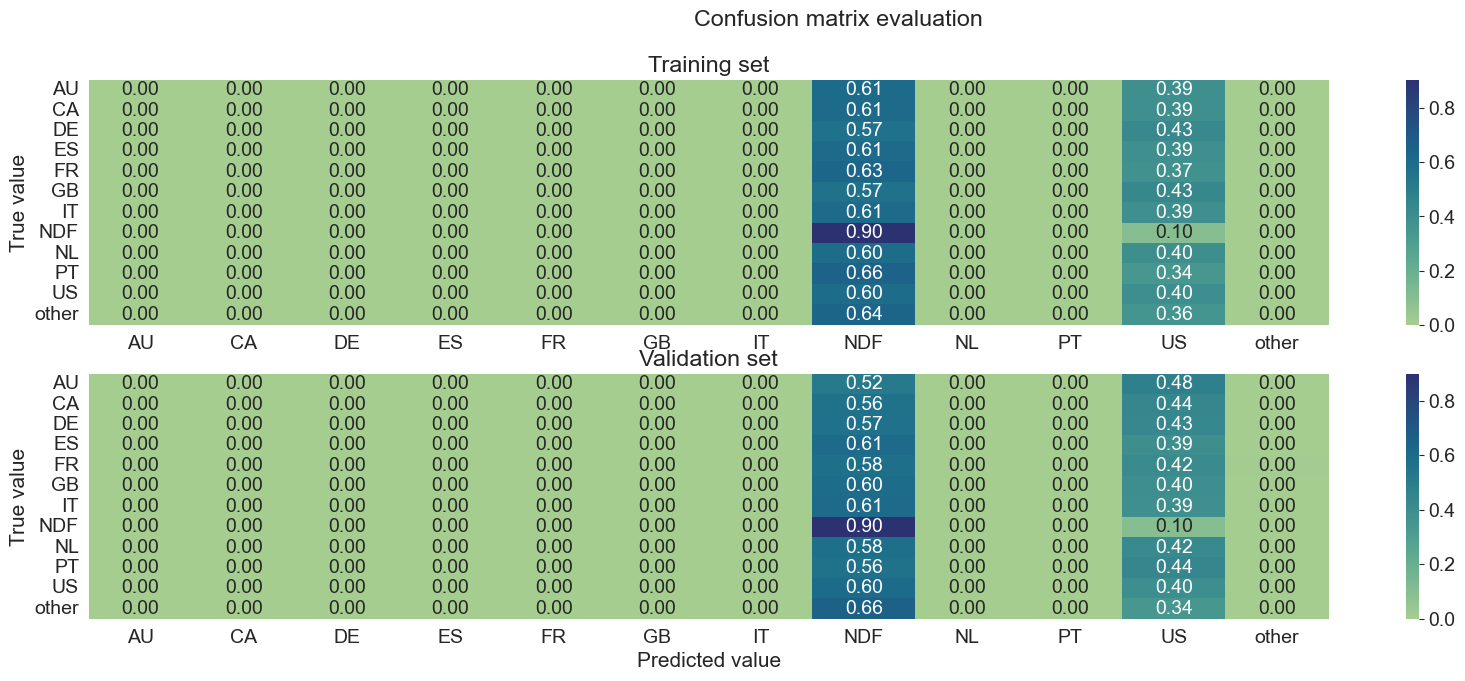

In [239]:
models_list, train_score, val_score = test_params_kfold('skl', 5, cf=True)
# models_list, train_score, val_score = test_params('kfold', 5, cf=True,n_estimators=100, learning_rate=0.1, max_depth=10, subsample=0.9, colsample_bytree=0.7)
print(train_score, val_score)

Let's try GBMS with default parameter, using Kfold validation and then, evalute it

0.7656639779984911 0.6861068934039147


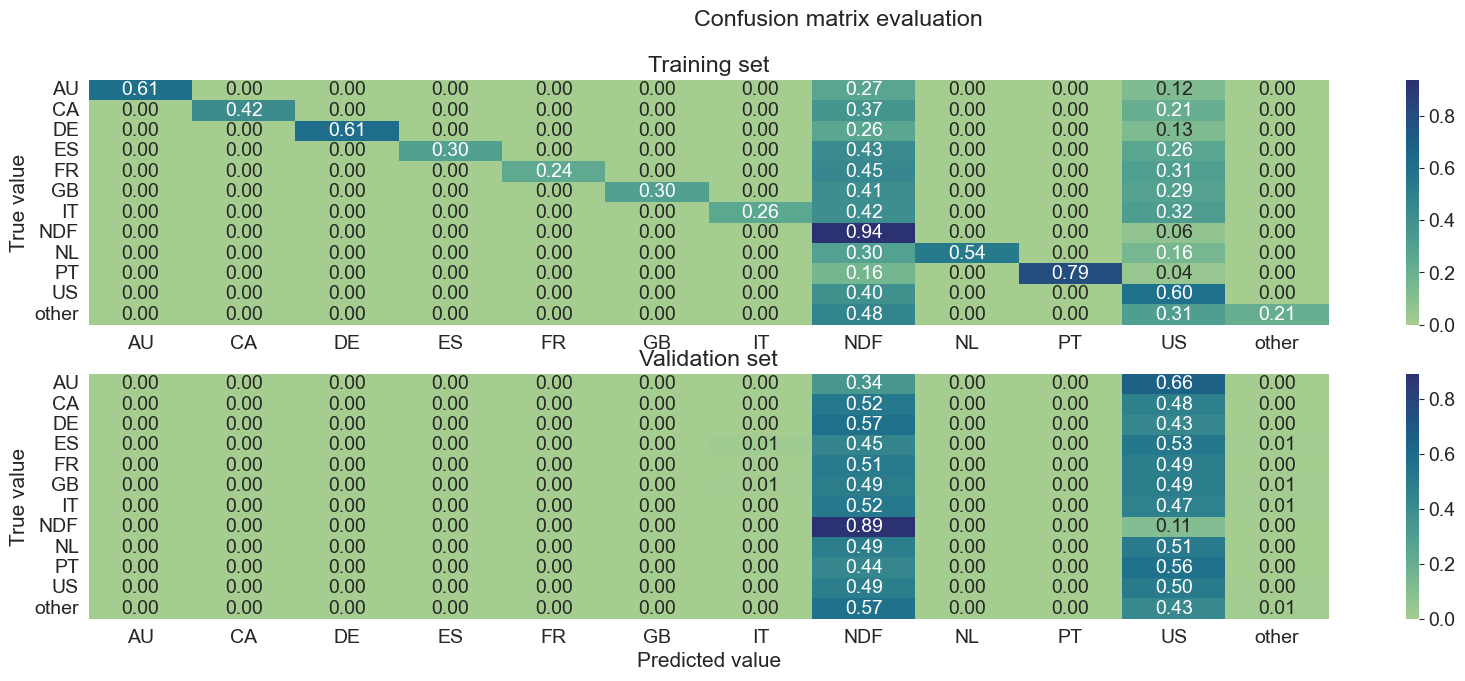

In [240]:
models_list, train_score, val_score = test_params_kfold('xgb', 5, cf=True)
print(train_score, val_score)

We can see that for this multi-class classification, XGBClassifier is doing a better job than Sklearn Logistic regression, thus, this will be chosen for tuning and finalizing the model.

In addition, the `feature_importance` can also be shown

In [ ]:
import seaborn as sns

importance_df = pd.DataFrame({
    'feature': X.columns,
    # Let's tale the first model in kfold process
    'importance': models_list[0].feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,2))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

## Hyperparameter Tuning and Regularization

First, let create a helper function to plot the `accuracy` vs `model_complexity`, which is super handy for hyperparam tuning

* Note that we will use train_test_split here without Kfold to save time and resources

In [230]:
X_train, train_targets, X_val, val_targets = sklearn_split_data(X, X_target, size=0.3)

In [241]:
def test_params_split(cf=False, **params):
    models, train_preds, val_preds = train_pred_evaluate('xgb', X_train, train_targets, X_val, val_targets, **params)
    tmp1, tmp2 = accuracy_scores(train_preds, train_targets, val_preds, val_targets)

    if cf: cfmatrix_eva(train_preds, train_targets, val_preds, val_targets)
    return models, tmp1, tmp2
    

In [242]:
def test_param_plot(param_name, param_values, cf=False, **fixed_params):
    train_accu, val_accu = [], [] 
    for value in param_values:
        params = {param_name: value}
        # Run model and evaluation
        model, train_rmse, val_rmse = test_params_split(cf=cf, **fixed_params, **params)
        train_accu.append(train_rmse)
        val_accu.append(val_rmse)
        # Debug
        print(f"Done with {value}")
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_accu, 'b-o')
    plt.plot(param_values, val_accu, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('Accuracy score')
    plt.legend(['Training', 'Validation'])

Following the guide to tune the XGBoost model with reference here https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

### 1. Fix learning rate and number of estimators for tuning tree-based parameters

In [243]:
models_list, train_score, val_score = test_params_split(cf=False, 
                learning_rate = 0.1, # Fix low value first
                max_depth = 5, min_child_weight = 1, gamma = 0,
                subsample = 0.8, colsample_bytree = 0.8, scale_pos_weight = 1)
                                    
print(train_score, val_score)

[19:36:01] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

0.7088047987224181 0.6901754067072616


### 2. Tune max_depth and min_child_weight

[20:01:03] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

Done with 3
[20:01:33] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

Done with 5
[20:02:21] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

Done with 7
[20:03:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

Done with 9


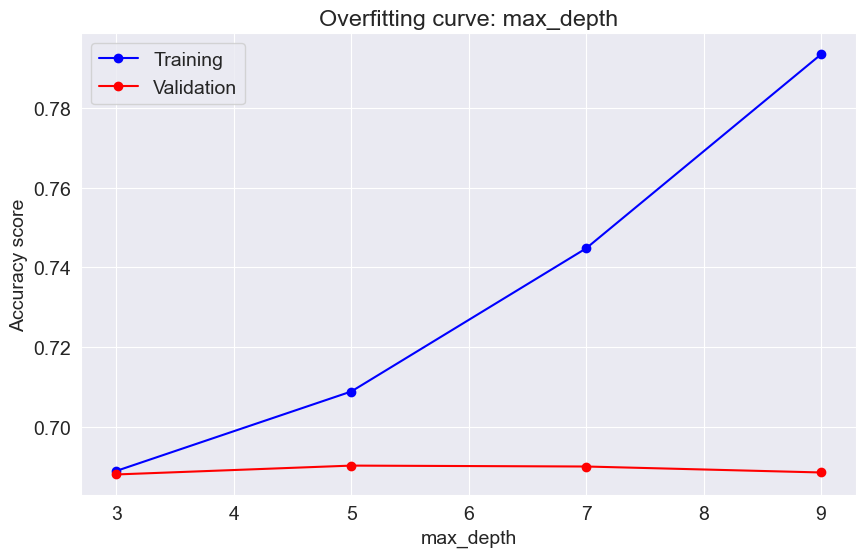

In [246]:
test_param_plot('max_depth', np.arange(3, 10, 2, dtype='int').tolist(), cf=False,
                learning_rate = 0.1, # Fix low value first
                min_child_weight = 1, gamma = 0,
                subsample = 0.8, colsample_bytree = 0.8, scale_pos_weight = 1,
                slient=True, verbosity=0)

Done with 1
Done with 3
Done with 5
Done with 7


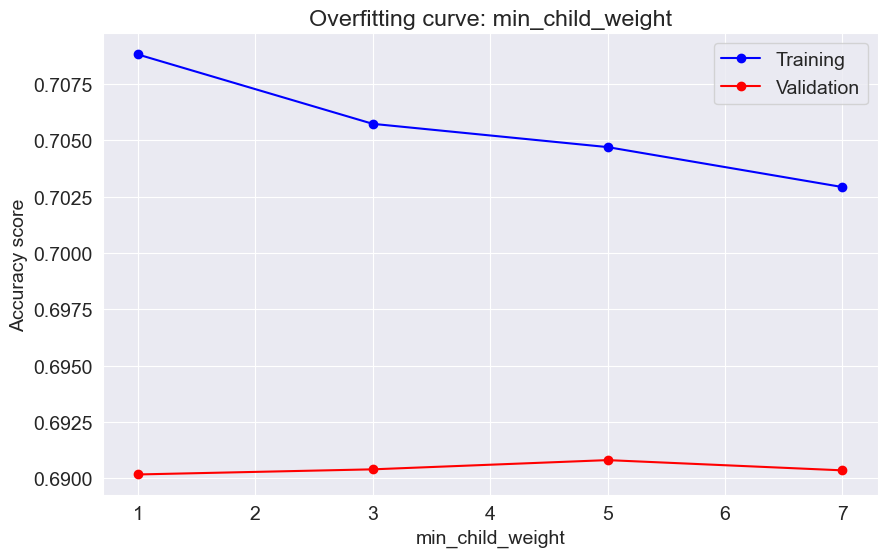

In [252]:
test_param_plot('min_child_weight', np.arange(1, 8, 2, dtype='int').tolist(), cf=False,
                learning_rate = 0.1, # Fix low value first
                max_depth = 5, gamma = 0,
                subsample = 0.8, colsample_bytree = 0.8, scale_pos_weight = 1,
                slient=True, verbosity=0)

With the `max_depth` parameters, the data itself could not generate good distribution of train and val set yet to evaluate the val set, thus, this parameter does not play such important role in tuning the model yet.
However, with `min_child_weight`, it is clear that the higher the parameter is, the worse the accuracy can get.

Hence, `max_depth` and `min_child_weight` can be choosen as 5. 

### 3. Tune gamma

Minimum loss reduction required to make a further partition on a leaf node of the tree (according the the XGBoost API). This param depends on both train and test set


Done with 0.1
Done with 0.30000000000000004
Done with 0.5000000000000001
Done with 0.7000000000000001


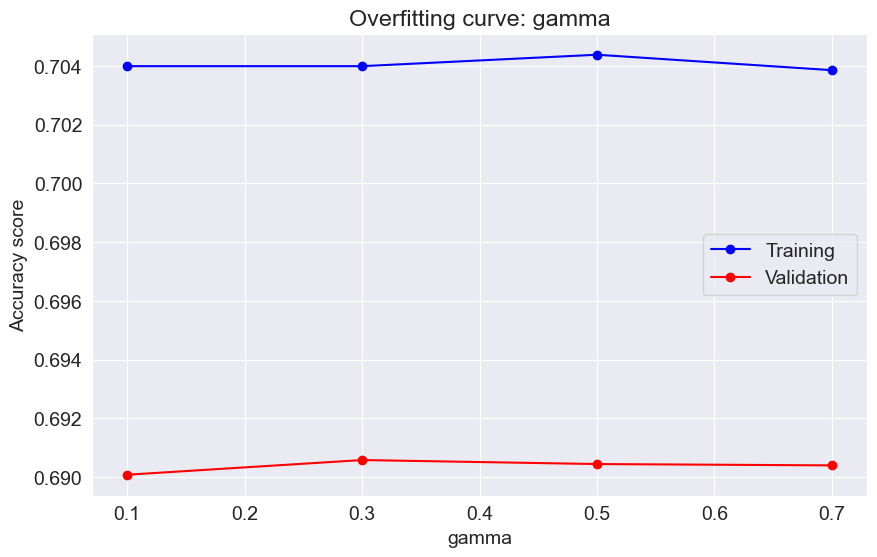

In [255]:
test_param_plot('gamma', np.arange(0.1, 0.8, .2, dtype='float').tolist(), cf=False,
                learning_rate = 0.1, # Fix low value first
                max_depth = 5, min_child_weight = 5,
                subsample = 0.8, colsample_bytree = 0.8, scale_pos_weight = 1,
                slient=True, verbosity=0)

As we can see, the gamma did not affect much of the evaluation, thus, let choose it as 0.3

### 4. Tuning subsample and colsample_bytree, Regularization Parameters


`subsample` and `colsample_bytree` related to how the decision trees are formed and ratio between test set
`reg_alpha`: L1 regularization term on weights (xgb’s alpha)

> Note the params subsample and colsample_bytree will be skipped since I not sure what do it mean yet

Done with 0.4
Done with 0.6000000000000001
Done with 0.8000000000000002
Done with 1.0000000000000002


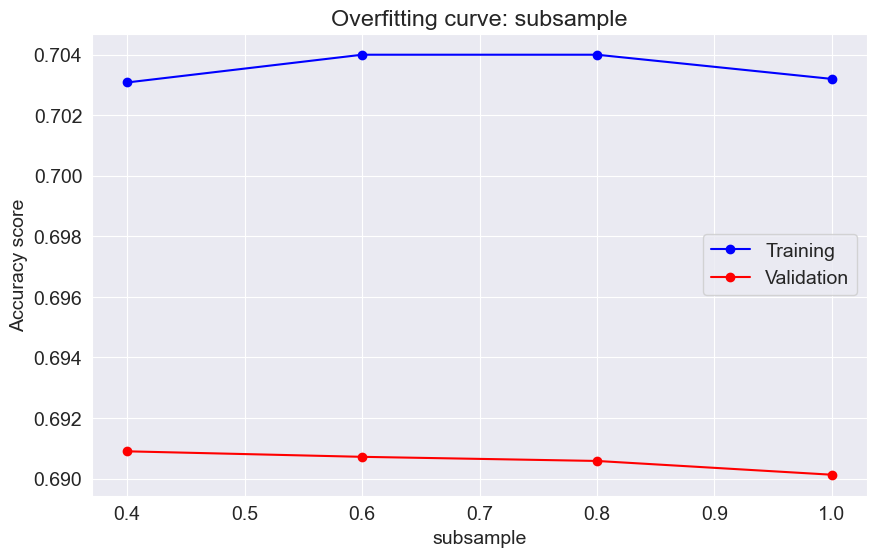

In [256]:
test_param_plot('subsample', np.arange(0.4, 1.1, .2, dtype='float').tolist(), cf=False,
                learning_rate = 0.1, # Fix low value first
                max_depth = 5, min_child_weight = 5, gamma = 0.3,
                colsample_bytree = 0.8, scale_pos_weight = 1,
                slient=True, verbosity=0)

Done with 0.4
Done with 0.6000000000000001
Done with 0.8000000000000002
Done with 1.0000000000000002


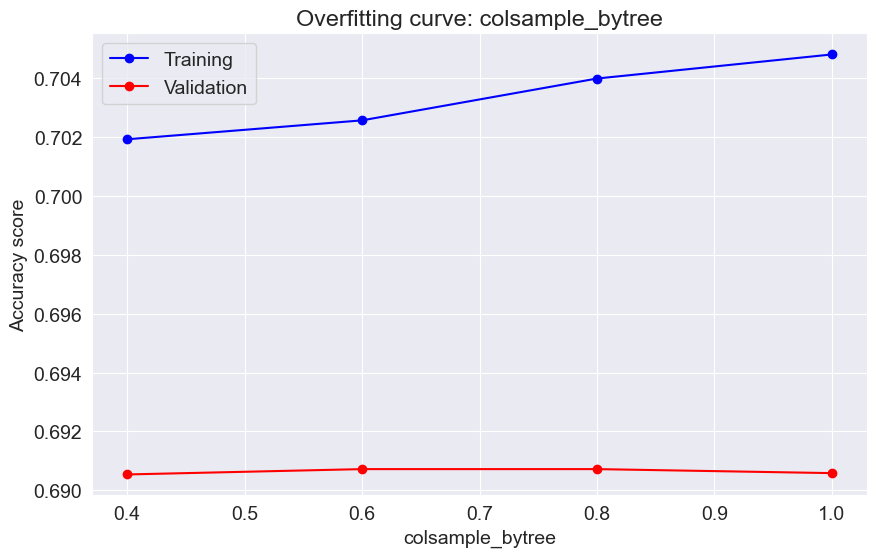

In [257]:
test_param_plot('colsample_bytree', np.arange(0.4, 1.1, .2, dtype='float').tolist(), cf=False,
                learning_rate = 0.1, # Fix low value first
                max_depth = 5, min_child_weight = 5, gamma = 0.3,
                subsample = 0.6, scale_pos_weight = 1,
                slient=True, verbosity=0)

Done with 1e-05
Done with 0.01
Done with 0.1
Done with 1
Done with 100


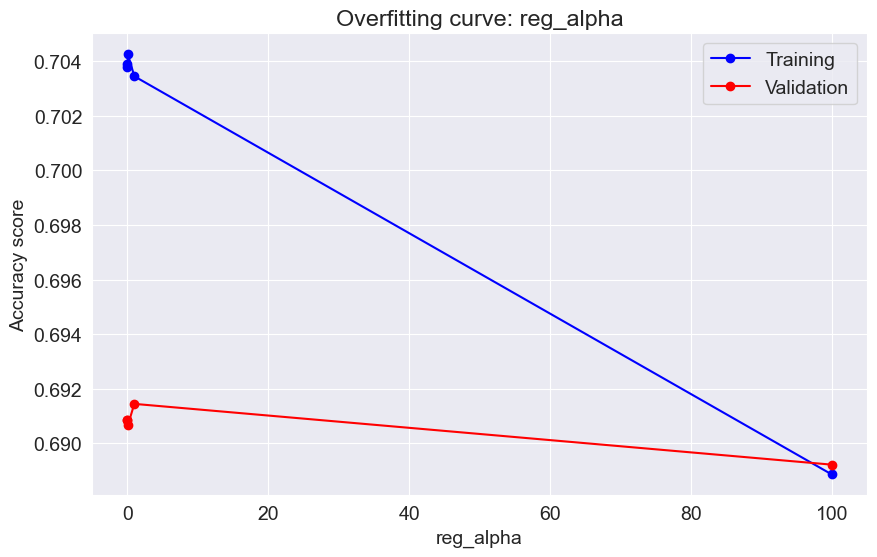

In [258]:
test_param_plot('reg_alpha', [1e-5, 1e-2, 0.1, 1, 100], cf=False,
                learning_rate = 0.1, # Fix low value first
                max_depth = 5, min_child_weight = 5, gamma = 0.3,
                subsample = 0.6, colsample_bytree = 0.8, scale_pos_weight = 1,
                slient=True, verbosity=0)


### 5. Lastly, reduce the `learning_rate` with increased number of trees

The scaling factor to be applied to the prediction of each tree. A very high learning rate (close to 1) will lead to overfitting, and a low learning rate (close to 0) will lead to underfitting.

First, let test the param first, then we can increase the `n_estimators` to enhance the forest

Done with 0.01
Done with 0.1
Done with 0.3
Done with 0.6
Done with 0.9
Done with 0.99


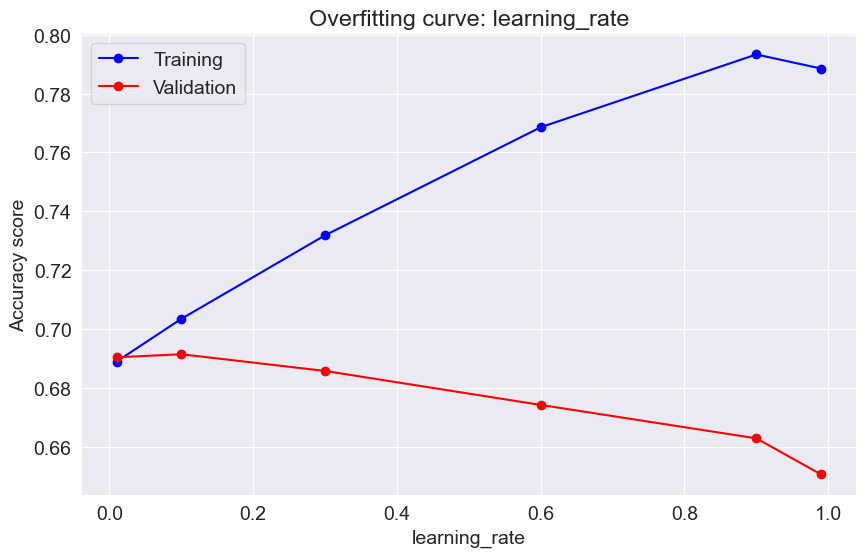

In [259]:
test_param_plot('learning_rate', [0.01, 0.1, 0.3, 0.6, 0.9, 0.99], cf=False,
                max_depth = 5, min_child_weight = 5, gamma = 0.3, reg_alpha = 1,
                subsample = 0.6, colsample_bytree = 0.8, scale_pos_weight = 1,
                slient=True, verbosity=0)

From here, the result is quite difficult to evalue the `learning_rate` parameter. It can be see that the accuracy of the train set increase by 2% between `learning_rate` value of 0.3 and 0.6, however, the validation accuracy only drops almost 1%. Hence, for best result, the `learning_rate` can be chosen as estimated 0.5

## Making predictions with optimal parameters

Let's train a final model on the entire training set with custom hyperparameters. 

In [260]:
model = XGBClassifier(n_jobs=-1, random_state=42, n_estimators=1000, learning_rate = 0.5,
                     max_depth = 5, min_child_weight = 5, gamma = 0.3, reg_alpha = 1,
                    subsample = 0.6, colsample_bytree = 0.8, scale_pos_weight = 1,
                    slient=True, verbosity=0)

In [261]:
%%time
model.fit(X, X_target)

CPU times: total: 1h 58min 13s
Wall time: 10min 59s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

Now that the model is trained, we can make predictions on the test set.

Train accuracy: 0.9438196120131419


Text(154.22222222222223, 0.5, 'True value')

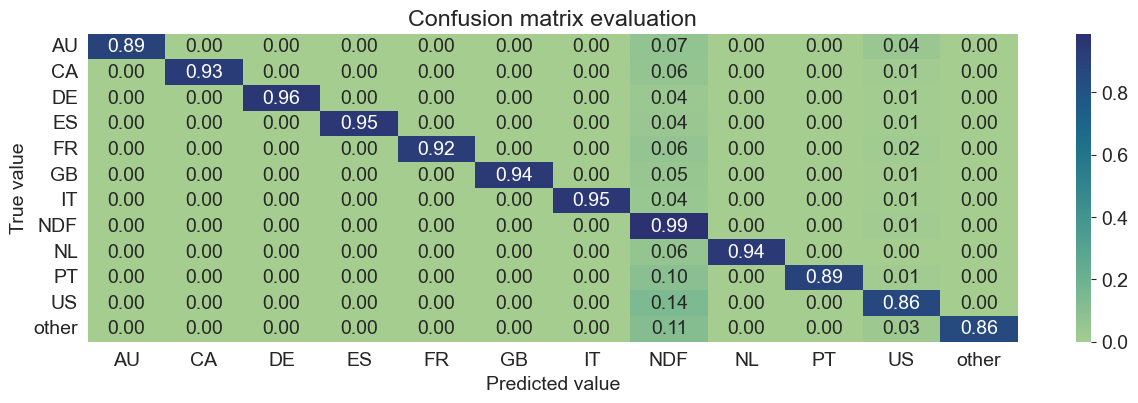

In [262]:
train_preds_test = model.predict(X)
train_accu = accuracy_score(train_preds_test, X_target)
print(f'Train accuracy: {train_accu}')

# Inverse labeling for plotting
train_preds_label = le.inverse_transform(train_preds_test)
train_targets_label = le.inverse_transform(X_target)
# Tranform to confusion matrix
train_cf = confusion_matrix(y_pred=train_preds_label, y_true=train_targets_label, normalize='true')

sns.heatmap(train_cf,
            annot=True, xticklabels=le.classes_, yticklabels=le.classes_,
            fmt=".2f", cmap='crest')
plt.title('Confusion matrix evaluation')
plt.xlabel('Predicted value')
plt.ylabel('True value')

The accuracy of the model on the train dataset show a significant increase in accuracy, thus, it is ready for the final job!

In [263]:
test_preds = model.predict(X_test)

Now, let put back the label for the results by using LabelEncoder above

In [264]:
submission_col = pd.Series(le.inverse_transform(test_preds))

In [265]:
submission_df = pd.concat([test_c_df['user_id'], submission_col], axis=1)
submission_df.rename(columns={0: 'country_destination'}, inplace=True)
submission_df

user_id country_destination
0      5uwns89zht                 NDF
1      jtl0dijy2j                 NDF
2      xx0ulgorjt                 NDF
3      6c6puo6ix0                 NDF
4      czqhjk3yfe                  US
...           ...                 ...
61622  cv0na2lf5a                 NDF
61623  zp8xfonng8                 NDF
61624  fa6260ziny                 NDF
61625  87k0fy4ugm                 NDF
61626  9uqfg8txu3                 NDF

[61627 rows x 2 columns]

We can now save the predictions as a CSV file for further submission

In [266]:
submission_df.to_csv('submission.csv', index=None)

## Conclusion

### a) Summary
From the AirBNB dataset with users information, the prediction on the target country can be computed accurately using the approriate models and technique
> Here, the datasets are firstly being downloaded, unzip and go through some cleaning and EDA
* The datasets also include 2 extra data, corresponding to the session log of the users and the further informationabout the country destinations
> Next, further preprocessing and feature engineering are required to not only to turn datasets that are easy for human interaction into a binary and numerical frame for the machine to learn but also to increase the learning ability for the models
>.
> When everything is prepared, the approriate model can be choosen through some testing and evaluating, in which the XGBClassifier is chosen for this particular multi-class classification problem.
* The target consists of 12 different labels, represent the different country destinations that were booked by the users
* The evaluation is carried out by `Kfold evaluation`, then, using `accuracy_score` and `confusion_matrix`
> Finally, the model is then going through the hyperparameter tunings to get optimals parameters that yield the best result, which then can be used to predict the test dataset.

### b) Evaluation
> Although the model can predict the train dataset with high accuracy, the validation evaluations during the hyperparam tuning stlll shown a slight concern about the model reliability. In regards to this overfitting problem, the few reasons may be the causes of it
* The insufficient dataset of the `session_df`: As being discussed above, the dataset didnot provide enough information for all the `user_id`, thus, after merging with the train and test data, there are still a significant missing of data
* The lack of feature engineering: As I am new to machine learning but have decided to take on this "challenging" problem, I felt like it hard to generate further feature from the given ones, which can enhance further the models. Speaking of the given datasets, the given features seem to not have much of relation among each other as well
* The missing of `timestamp_first_active` in test datasets (it appears to be the same as `first_date_booking`) results in the ignoring of the whole DateTime columns.
* Further research can be applied to explore and merge more informations gathered from the `country_df` (such as distances, locations and languages), which can be linked with the browsers, the affiliate associated with that areas/nations and the preferred langauges (provided in the train and test datasets), however, with the time constraints, I have not managed to do this
* Lastly, the hyperparameters can be carried out in a more effective way, by combine two related parameters and test it together with various value, instead of separate and test individually.

### c) Future work idea:
* Learn more about other parameters of the models and also more way of evaluating the results, which can help directing a better strategies when fine-tuning the params
* Get more sufficient information to merge in, do some more feature engineerings
* Reasearch further to make used of the `country_destination` information (from the `country_df`)
* Explore other Classifier models and their associated parameters 

## Reference

* https://towardsdatascience.com/xgboost-for-multi-class-classification-799d96bcd368
* https://xgboost.readthedocs.io/en/stable/python/python_api.html
* https://jovian.com/fidekg123/zillow-prize-prediction#C171
* https://jovian.com/learn/machine-learning-with-python-zero-to-gbms
* https://github.com/HarshaGoonewardana/Evaluating-Multi-Class-Classifiers/blob/master/Multi_Class_Evaluation_Metrics.ipynb
* https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
* https://towardsdatascience.com/xgboost-for-multi-class-classification-799d96bcd368